In [17]:
import random
import warnings
from pathlib import Path

warnings.filterwarnings("ignore")
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd

from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss
from neuralforecast.models import LSTM, NHITS

In [9]:
DATA_PATH = Path("data")
HOURLY_TRAIN = DATA_PATH / "M4-Hourly.csv"
HOURLY_TEST = DATA_PATH / "M4-Hourly-test.csv"

In [4]:
def plot_grid(df_train, df_test=None, plot_random=True, model=None, level=None):
    fig, axes = plt.subplots(4, 2, figsize=(24, 14))

    unique_ids = df_train["unique_id"].unique()

    assert len(unique_ids) >= 8, "Must provide at least 8 ts"

    if plot_random:
        unique_ids = random.sample(list(unique_ids), k=8)
    else:
        unique_uids = unique_ids[:8]

    for uid, (idx, idy) in zip(unique_ids, product(range(4), range(2))):
        train_uid = df_train.query("unique_id == @uid")
        axes[idx, idy].plot(train_uid["ds"], train_uid["y"], label="y_train")
        if df_test is not None:
            max_ds = train_uid["ds"].max()
            test_uid = df_test.query("unique_id == @uid")
            for col in ["y", f"{model}-median", "y_test"]:
                if col in test_uid:
                    axes[idx, idy].plot(test_uid["ds"], test_uid[col], label=col)
            if level is not None:
                for l, alpha in zip(sorted(level), [0.5, 0.4, 0.35, 0.2]):
                    axes[idx, idy].fill_between(
                        test_uid["ds"],
                        test_uid[f"{model}-lo-{l}"],
                        test_uid[f"{model}-hi-{l}"],
                        alpha=alpha,
                        color="orange",
                        label=f"{model}_level_{l}",
                    )
        axes[idx, idy].set_title(f"M4 Hourly: {uid}")
        axes[idx, idy].set_xlabel("Timestamp [t]")
        axes[idx, idy].set_ylabel("Target")
        axes[idx, idy].legend(loc="upper left")
        axes[idx, idy].xaxis.set_major_locator(plt.MaxNLocator(20))
        axes[idx, idy].grid()
    fig.subplots_adjust(hspace=0.5)
    plt.show()

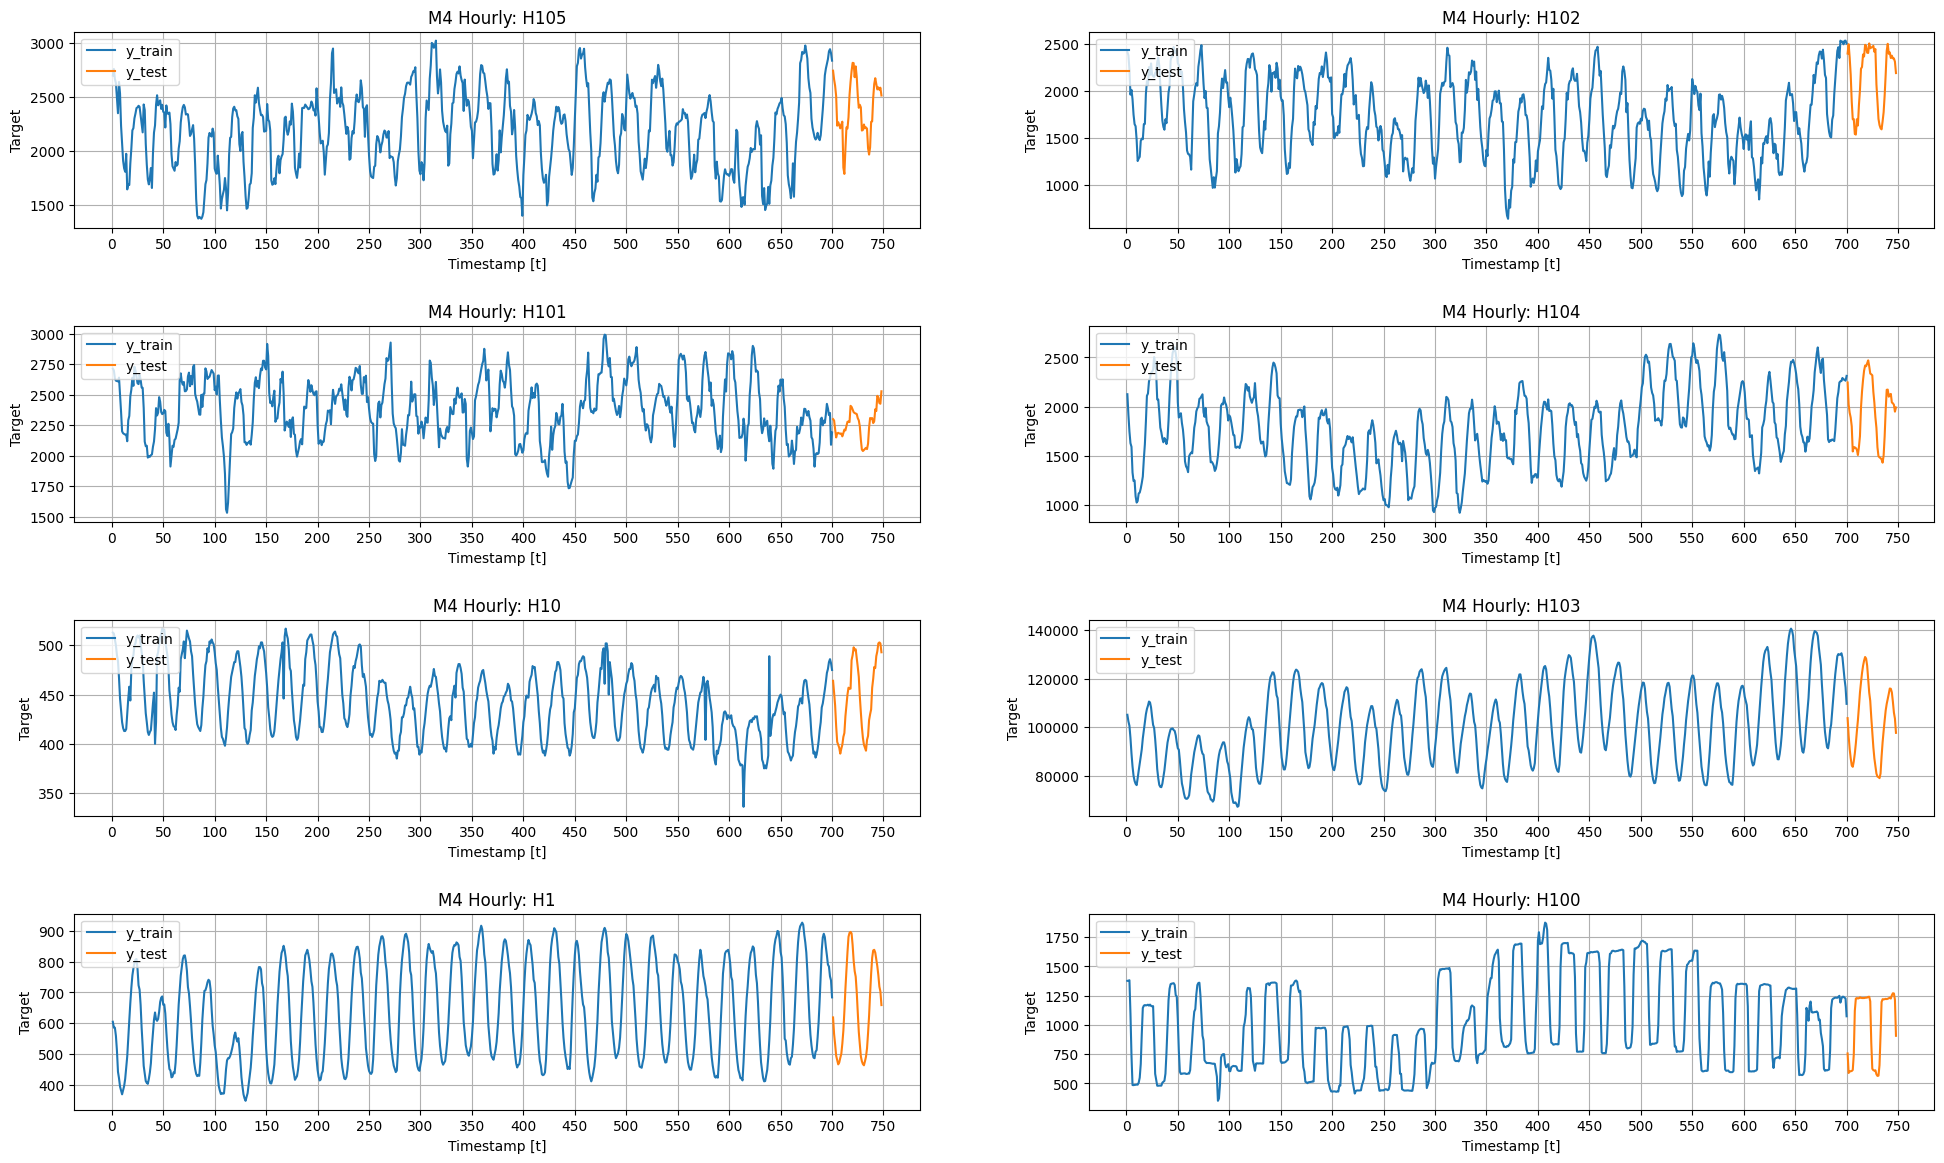

In [16]:
Y_train_df = pd.read_csv(HOURLY_TRAIN)
Y_test_df = pd.read_csv(HOURLY_TEST).rename(columns={"y": "y_test"})

n_series = 8
uids = Y_train_df["unique_id"].unique()[:n_series]
Y_train_df = Y_train_df.query("unique_id in @uids")
Y_test_df = Y_test_df.query("unique_id in @uids")

plot_grid(Y_train_df, Y_test_df)

In [18]:
horizon = 48
levels = [80, 90]
models = [
    LSTM(input_size=3 * horizon, h=horizon, loss=MQLoss(level=levels), max_steps=1000),
    NHITS(
        input_size=7 * horizon,
        h=horizon,
        n_freq_downsample=[24, 12, 1],
        loss=MQLoss(level=levels),
        max_steps=2000,
    ),
]
nf = NeuralForecast(models=models, freq="H")

[rank: 0] Seed set to 1
[rank: 0] Seed set to 1
